In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (12, 4)
from scipy.io.wavfile import read
from IPython.display import Image, Audio

## More Spectral Features

Since there were some features that we didn't have time to go over in class, or skipped over, I made this separate notebook to ensure you have reviewed all the relevant spectral features.

### What do we mean by "spectral"?

Recall that the spectrum of a signal describes the distribution and magnitude of frequencies in the signal. While we might think of this as measuring frequency content, various statistics about the spread, shape, or change in frequency content can actually tell us things about the timbral quality of the signal.

### Bandwidth
Is a measure of what range of frequencies are present in a signal. This is sometimes used to discrimitate between speech and music. (Music typically will have a larger bandwidth than speech).

`librosa.feature.spectral_bandwidth` is a function for calculating bandwidth. We can also calculate it manually if we have the complete spectrum of the signal. **The bandwidth is simply the difference between the highest and lowest frequency.**

### Spectral Rolloff
The spectral rolloff point is the frequency below which some cutoff (typically 85%) of the spectral energy exists. The roll-off frequency can be used to distinguish between harmonic (below roll-off) and noisy sounds (above roll-off). It is sometimes used to discriminate between different types of music tracks. 

`librosa` also has a function for calculating this feature.

The formula for calculating can be defined as follows:
$$ \sum_{n=0}^{R_n -1} = \sum_{n=0}^{N-1} .85 * {|X[k]|_n}$$

Where $R_n$ is the frequency below which 85% of the spectrum is concentrated.

see [Music Data Mining, p.52](https://ebookcentral-proquest-com.prx.library.gatech.edu/lib/gatech/reader.action?docID=1633711&ppg=68)

### Spectral Centroid 
A measure of the "point of balance" for a spectrum, or a measure of the average frequency of the signal.  Music tends to have a higher (and more stable) spectral centroid than speech, especially when the music contains percussion.

You may use your own function you created for calculating spectral centroid, or else simply use the Librosa one:

Text(0.5, 0, 'Time')

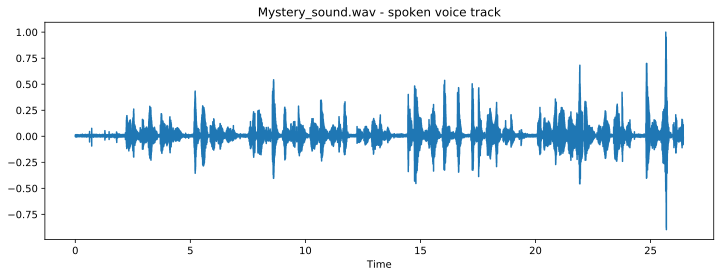

In [2]:
(fs, x) = read('../uploaded_files/mystery_sound.wav')
newx = x/np.abs(x.max()) #normalize from -1 to 1
t = np.linspace(0,len(newx)/fs,len(newx)) #create time axis points
plt.plot(t, newx)
plt.title('Mystery_sound.wav - spoken voice track')
plt.xlabel('Time')

In [3]:
#As a reminder, here's the clip
Audio('../uploaded_files/mystery_sound.wav')

Text(0.5, 0, 'Time')

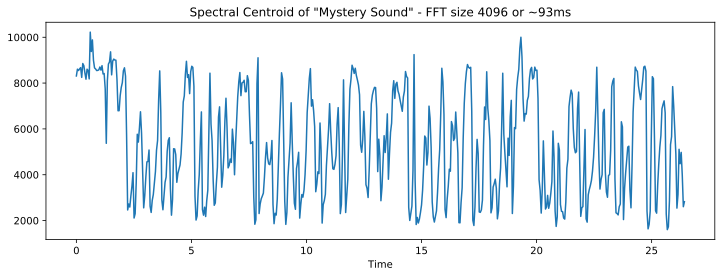

In [4]:
# We can use the librosa feature to calculate spectral centroid over a series of frames.
from librosa.feature import spectral_centroid
#spectral centroid of mystery sound:
#remember to convert integer to float for librosa, and to manually set the sample rate 
sp_cent = spectral_centroid(newx.astype(float), sr=fs, n_fft=4096, hop_length=2048)[0] #because of the shape of output, you need to select the first item from the multidimensional array
t2 = np.linspace(0,len(newx)/fs,len(sp_cent))#manually create time axis
plt.plot(t2,sp_cent)
plt.title('Spectral Centroid of "Mystery Sound" - FFT size 4096 or ~93ms')
plt.xlabel('Time')

It is a good idea to normalize the feature data, to facilitate comparison across other clips. You may want to make a 'normalization' function to facilitate this step. 

Recall that we can also use the `librosa.frames_to_time` function to display the frame values over the appropriate time window. Remember that the function needs to know the original sample rate, as well as the FFT size and hop size that was used to calculate the frames in the first place in order to "put them back" in the time domain.

Text(0.5, 1.0, 'Audio (blue) and Spectral Centroid (red)')

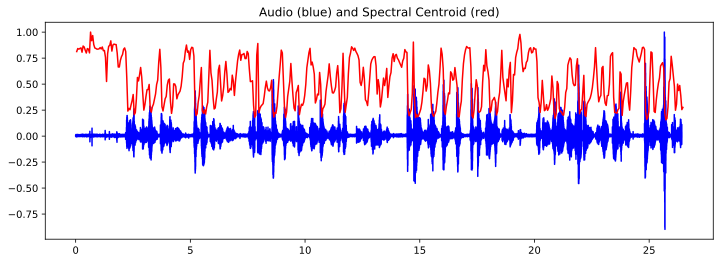

In [5]:
frames = range(len(sp_cent))
t3 = librosa.frames_to_time(frames, sr=fs, hop_length=2048, n_fft=4096) #use librosa to create time axis
n_sp_cent = sp_cent/np.abs(sp_cent.max()) #normalize values
plt.plot(t, newx, 'b', t3, n_sp_cent, 'r')
plt.title('Audio (blue) and Spectral Centroid (red)')

### Spectral Flux
Just like signal time-variance can be represented through a signal's envelope, spectral time-variance (spectral flux) is manifested as changes in the frequency and amplitude of a complex tone's components with time, and can be represented through time-variant spectra (i.e., spectrogram), or individual component amplitude/frequency envelopes. 

**Spectral Flux measures how quickly the spectrum of a signal is changing**, calculated by comparing the current value of each (normalized) magnitude spectrum bin in the current window from the corresponding values of the previous window. Each of these differences is then squared, and the result is the sum of the squares.

The spectral flux is used heavily in onset detection and other rhythmic features, and like ZCR, is also used in speech detection since spectral flux is typically higher for speech than music. 

Low results indicate steady-state input signals or low input levels. That is, during the stationary
parts of the signal, such as during a note or a pause, the flux will be small (or low) and pitch changes or
new note should result in peaks.

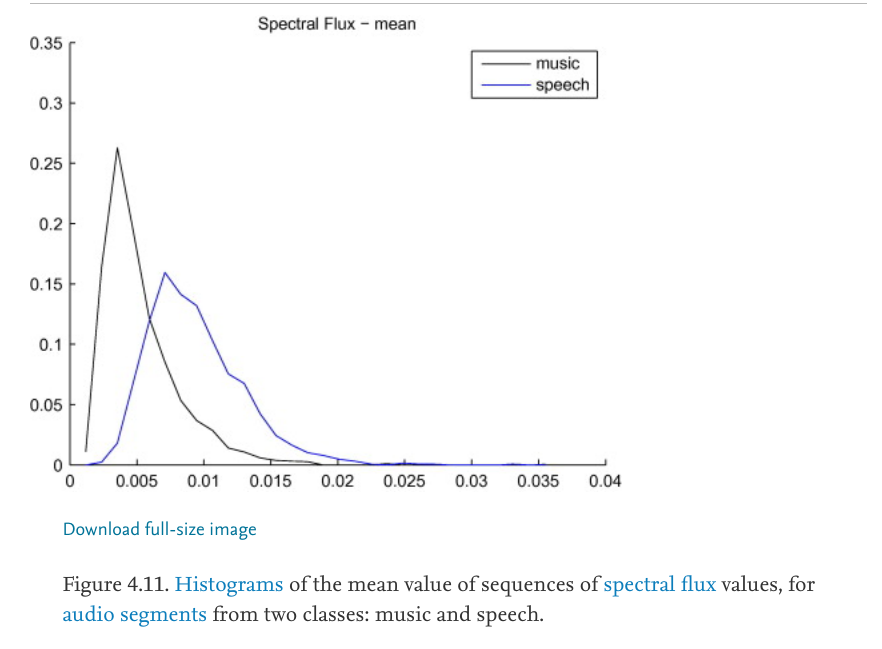

In [6]:
Image('../images/spectralFlux.png')
#Axes not labelled: y-axis are proportions, x-axis are means

### Spectral Spread
The Spectral Spread, sometimes also referred to as instantaneous bandwidth,
describes how the spectrum is concentrated around the Spectral Centroid
and represents a more technical description of spectral shape.

**Possible role in genre classification:**

Excerpts of electronic and popular music are (usually) more widely spread around their centroid than classical and jazz music (for example). 

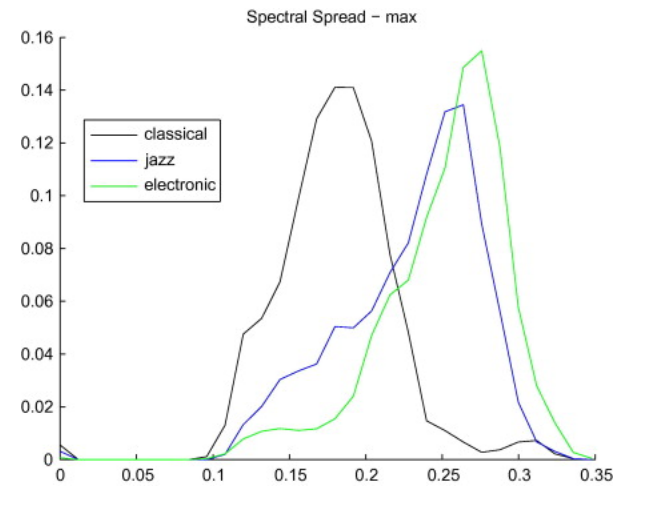

In [7]:
Image('../images/spectralSpread.png')

### Related features
Many of these extracted features will exhibit correlations with each other. For instance, higher spectral spread will be correlated with a higher spectral rolloff.

When building complex algorithms for performing some task (like genre classification), it is common to test how well some particular feature contributes *above and beyond* the other features it is correlated with.  

### Mel Frequency Cepstral Coefficients
The Mel Frequency Cepstral Coefficients (MFCCs) are a compact (but complicated) representation
of the shape of the spectral envelope of an audio signal based on the **mel frequecy scale**

#### Mel Scale
A **mel** is a unit of pitch defined so that pairs of sounds which are
perceptually equidistant in pitch are separated by an equal number of mels. In other words, the mel
scale is a "perceptually-motivated" scale of frequency intervals, which, if
judged by a human listener, are perceived to be equally spaced. Said another way, the Mel scale relates the perceived frequency of a tone to the actual measured frequency. (e.g., Humans are better at identifying small changes in speech at lower frequencies). 

Notice the scale appears roughly linear through ~700-1000Hz after which it becomes closer to logarithmic. 

The scale was derived from experiments with human listeners. However, these experiments were done in the 1950s, and some modern audiologists think the scale is biased. According to this scale, in order to hear an octave doubling, you use the mel scale as the reference -- so 1000 mels doubled would equal 2000 mels, which should sound like an octave jump. This translates (if you look up the mel to Hz using the chart) to 1000Hz and 3500Hz!! (Use your sine tone generators to test this for yourself!)

Anyway, the mel scale is the basis for MFCCs which are widely used in MIR (and actually work very well, regardless of whether the scale is flawed or not!)

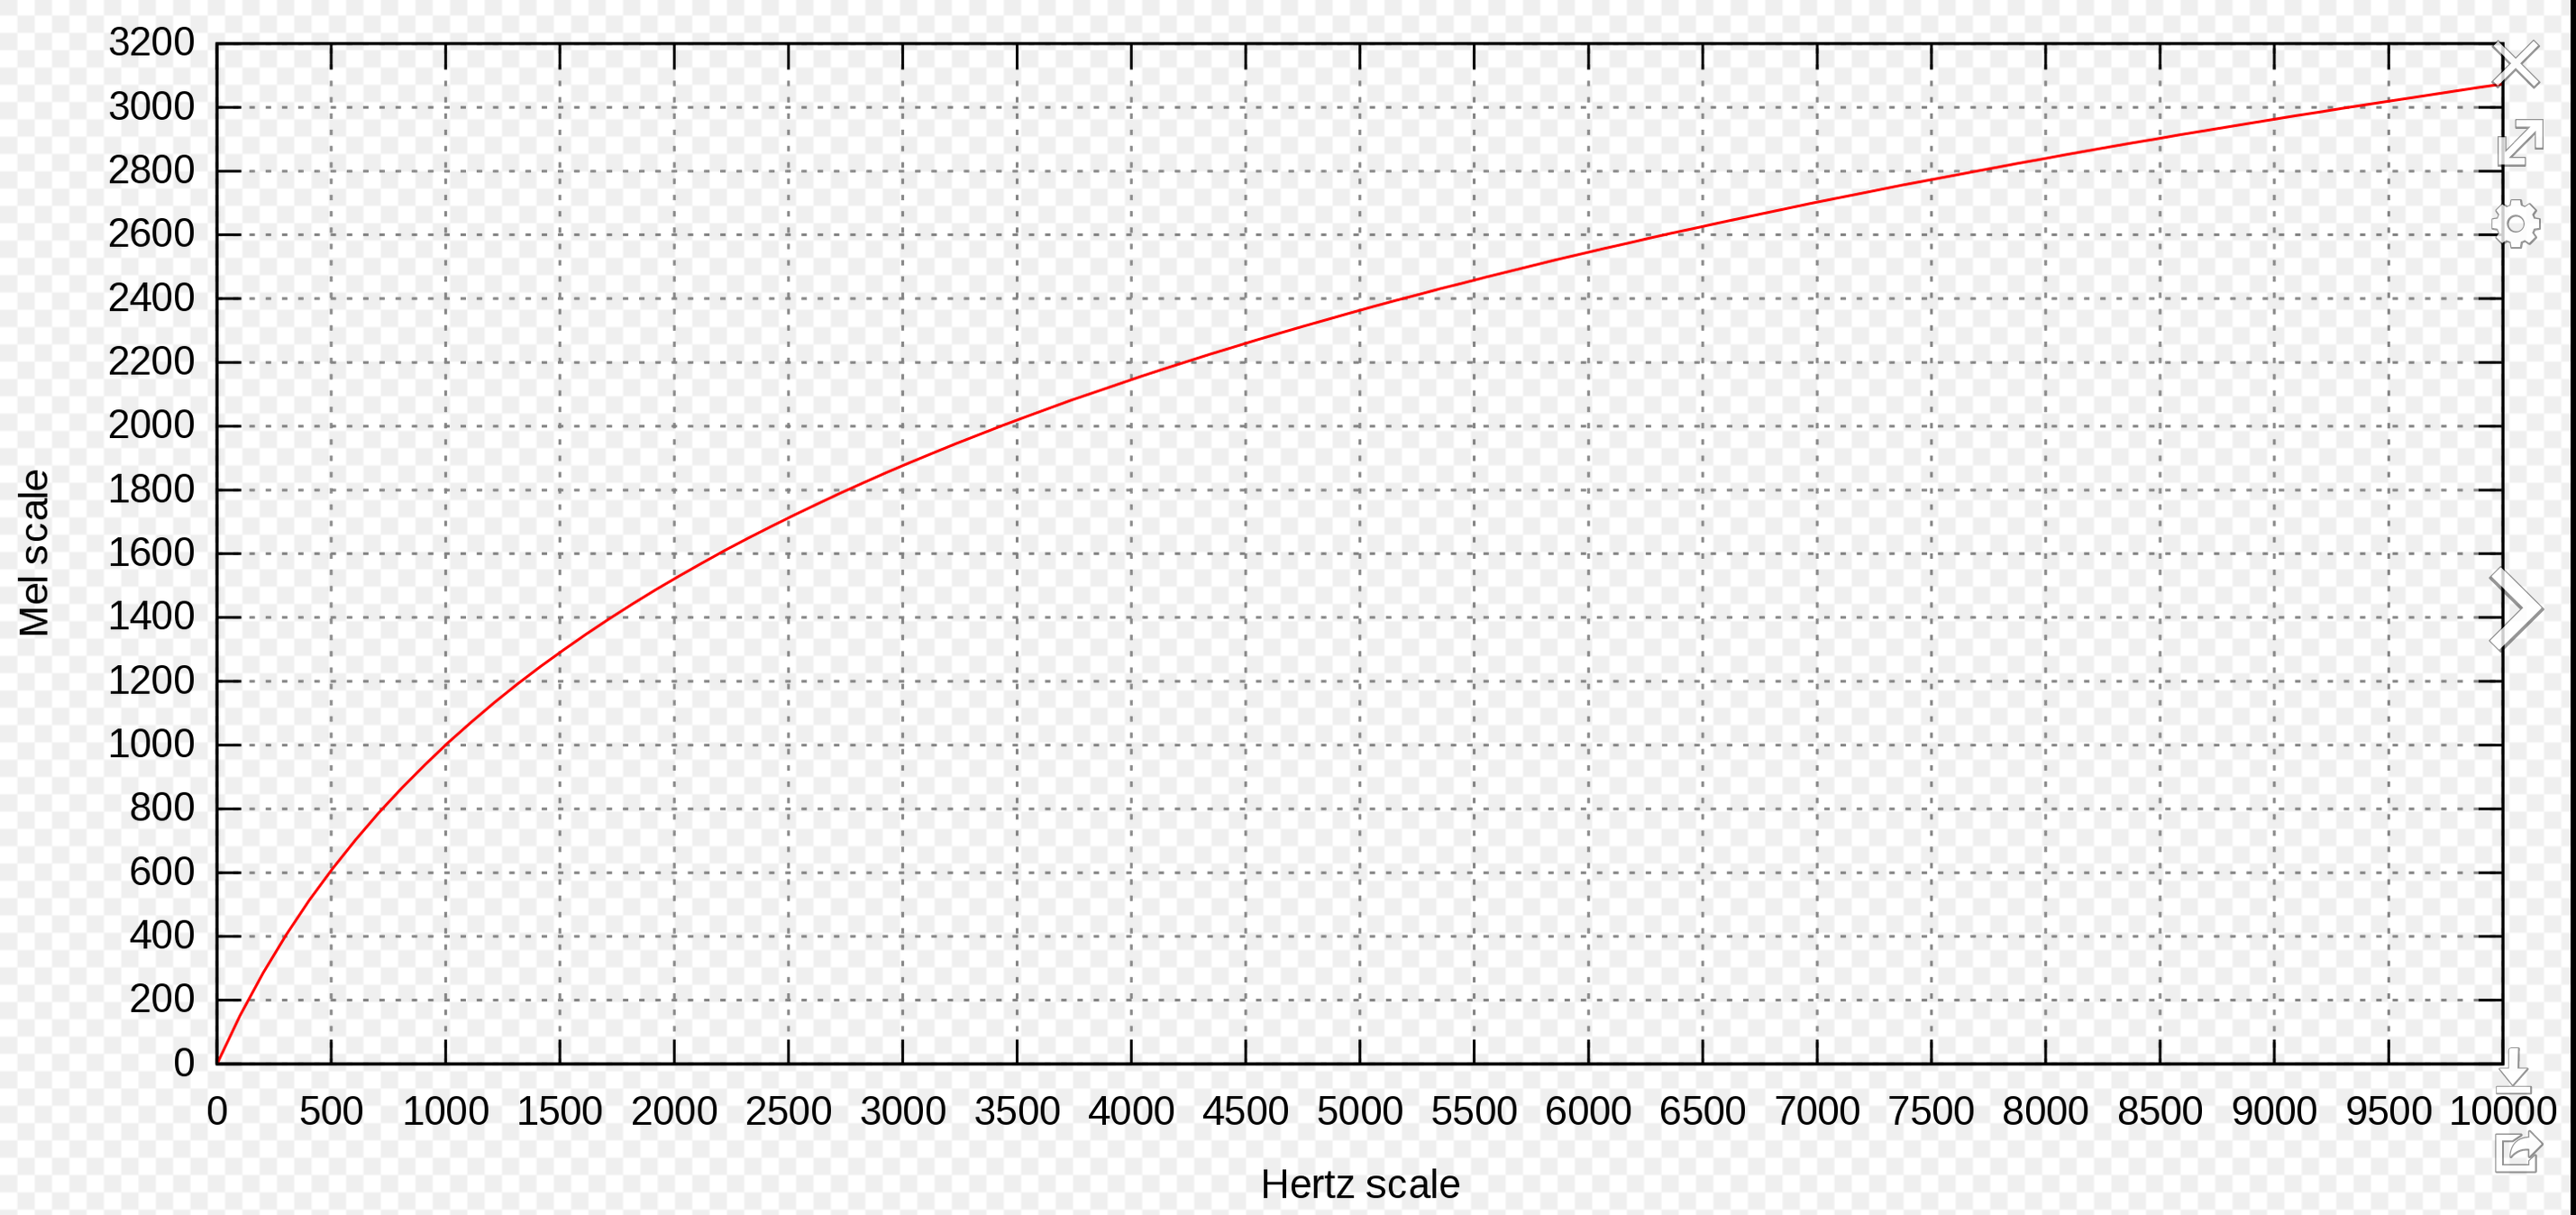

In [8]:
Image('../images/melScale.png') #download from Canvas if this isn't showing.

The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of coefficients that concisely describe model the overall shape of a spectral envelope. In MIR, they are widely used in speech recognition systems. They have proven useful in a variety of tasks including speech/music discrimination and genre classification.

The mel scale gets segmented into $Q$ bands of constant (mel) width, and the mel frequencies within each band are then aggregated. On the linear Hz scale this yeilds $Q$ bands with non-uniform bandwidth which are supposed to relate closely to the critical bands. The bands are formed using half-overlapping triangular weighting functions with the typical number of total bands usually set to 40, where the first ~13 are roughly equally spaced (up through 1000Hz) after which the remaining 27 mel bands are arranged logarithmically.

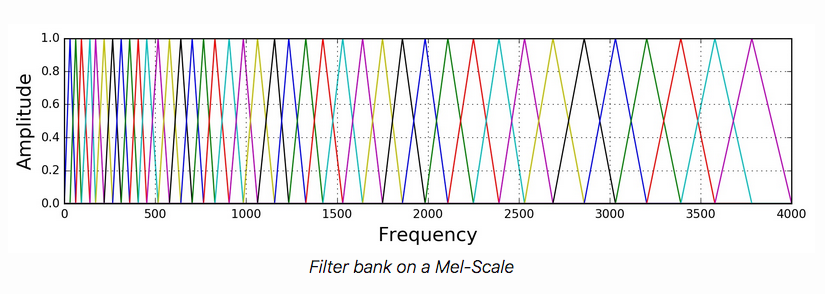

In [9]:
Image('../images/filterbanks.png')

To actually compute the MFCCs (Mel Frequency Cepstrum Coefficients), we take the logs of the powers of each filterbank energies (to account for the non-linear relationship between the sound pressure level and the perceived mel spectrum loudness), and then perform a Discrete Cosine Transform (akin to an inverse DFT) on the log filterbank energies as if it were a signal. 

Thus, MFCCs are a "multidimensional" feature meaning the calculation will return multiple values (one per filterbank) for every analysis (STFT) window. The number of filterbanks can vary (some implementations seem to only use 26 and not 40). In addition, the actual total number of coefficients you retain is variable. For instance, you could choose to use only 20 coefficients instead of 40. It is common in speech recognition, for example, to only use the first 13 coefficients and discard the rest. (This reduces the dimensions of the data, while keeping the most valuable information.)

You should read about calculating MFCCs in the recommended reading on Canvas, and you should also look up the package documentation [here](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html?highlight=mfccs)

Note that despite their proven usefulness in many tasks such as speech detection, genre detection, etc., it remains difficult to relate particular 'MFCC profiles' (or weightings) to any particular audible feature of an input signal.

Since this feature does not give a single value per frame (like the others), but rather a vector of values per frame, we get a different output. To graph the output, then, we have to use either `plt.imshow` `librosa.display.specshow` -- I show both options below.

It is important to note, however, that the utility of plotting the output of MFCCs is fairly limited. 

In [10]:
mfcc_data= librosa.feature.mfcc(y=newx,sr=fs,n_mfcc=20)
mfcc_data.shape

(20, 2277)

Here we have 2277 frames with 20 MFCCs in each.  Note that the very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. For this reason it is commonly discarded when performing classification. Here, we will look at the entire output.

Text(0.5, 1.0, 'MFCCs')

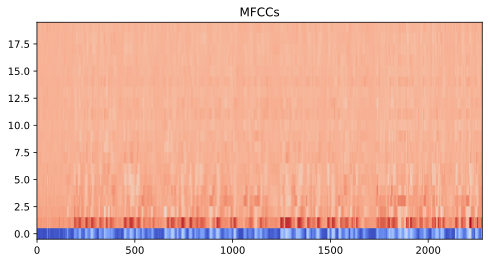

In [11]:
plt.figure(figsize=(8,4))
plt.imshow(mfcc_data, aspect='auto', origin='lower', cmap='coolwarm')
plt.title('MFCCs')

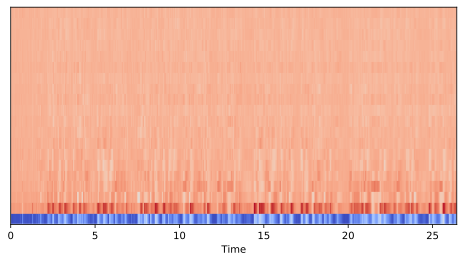

In [12]:
from librosa import display
plt.figure(figsize=(8,4))
display.specshow(mfcc_data, sr=fs, x_axis='time')

### Feature vector
A common way of organizing data when you want to extract several features from a single song (and then do the same process for multiple songs) is to organize the values for each extracted feature into a list of arrays (or list of lists).  This results in what is typically referred to as a **feature vector**.

Features are then typically normalized and assembled into a large table or dataframe for ease of analysis. We'll learn about how to do this next week.